In [320]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython) {
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [321]:
# change the cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [322]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import warnings
warnings.filterwarnings('ignore')
from more_itertools import chunked
# import all relevant func and modules from a companion .py file
from supp_lib import *
# import all samples as dictionary ...
from samples import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Figure 4 is based on several important BED-files ...

In [323]:
feat_names = OrderedDict()
feat_names["tssp"] = "ActiveTSSplus-NO-CTCF-5bp.bed"
feat_names["tssm"] = "ActiveTSSminus-NO-CTCF-5bp.bed"
feat_names["ddx55-nt"] = "NT-DDX55-NO-CTCF-no-activeTSS-NO-CTCF"
# feat_names["ddx55-iaa"] = "IAA-DDX55-NO-CTCF-narrowPeaks-new-no-activeTSS"
feat_names["taf5l-nt"] = "NT-TAF5L-NO-CTCF-no-activeTSS-NO-CTCF"
# feat_names["taf5l-iaa"] = "IAA-TAF5L-NO-CTCF-narrowPeaks-new-no-activeTSS"


## Read `feature_of_interest` that we want to look at using stackups ...
### we can also generate some random locations from hg19 using `generate_random_bed` ...

In [324]:
# bf is short for bioframe here ...
dfs = OrderedDict()
for k in feat_names:
    dfs[k] = bf.read_table(
        feat_names[k],
        names=["chrom","start","end"],
        usecols=(0,1,2),
        index_col=None
    )
    dfs[k] = dfs[k].sort_values(["chrom","start"])
    dfs[k] = dfs[k][dfs[k]["chrom"].isin(autosomal_chroms)]
    dfs[k] = dfs[k].reset_index(drop=True)
# merge_radius = 500
# df_merged = bf.merge(df, min_dist=merge_radius)
# print(f"number of candidate features before and after merging: {len(df)} -> {len(df_merged)}")

### explore spacing and footprints of the features being explored ...

simply plot distributions of the spacings between adjacent features and their sizes `end - start`  as well ...


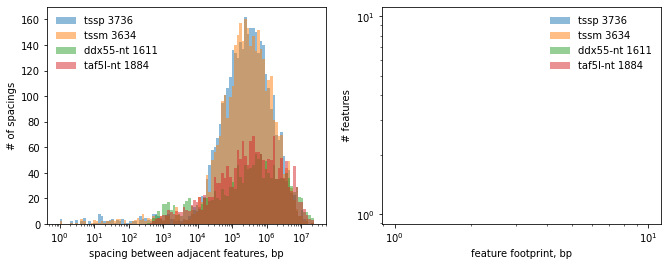

In [325]:
# just an overview of all of them together ...
plot_spacing_footprint_distros(dfs)

### in our analyses (insulation/compartments) we wouldn't resolve features that are too close ...
#### let's see what clustering those adjacent ones could do for us
#### let's try to pick a good clustering "radius" first - should be  around ~1-10kb ...

it's actually merging that we're doing - i.e. we don't need to know cluster information - just need to collapse nearby intervals into larger ones

to see how varying clustering radius affects the results see the gist : blah ...

### Not sure if we'd need to do it here, given the lare footprint of the G4 related peaks !!!...

### let's have the original CTCF and RAD21 peak calls here to do count them along our stackups as well...

### after we explored how our features (intervals) are spaced and distributed
#### we can move on to the stackups - for different samples, different types of tracks, etc

In [326]:
#let's describe our samples that we want to have in Figure 1 ...
fig4_samples = ["rad21_CTCF","rad21_noCTCF","ins_CTCF","ins_noCTCF","ddx_CTCF","ddx_noCTCF",'taf5l_CTCF','taf5l_noCTCF','h3k4_r1',"mrna_ctcf",'input_CTCF','input_noCTCF']

titles = fig4_samples

bw_fnames = OrderedDict()
binsizes = {}
flanks = {}
limss = {}
cmps = {}
norms = {}
for s in fig4_samples:
    bw_fnames[s] = samples[s]["fname"]
    binsizes[s] = samples[s]["binsize"]
    flanks[s] = samples[s]["flank"]
    limss[s] = samples[s]["crange"]
    cmps[s] = samples[s]["cmap"]
    norms[s] = samples[s]["norm"]

### next is computation heavy step - stackups using bbi ...

In [327]:
# do all stackups with the parameters ...
stackup_dict = OrderedDict()
for k in dfs:
    stackups = {}
    print(f"going to stackup features {k}:({len(dfs[k])}) ...\n\n")
    for s in bw_fnames:
        print(f"stacking up {s} ...")
        %time stackups[s] = rstacks( bw_fnames[s], dfs[k], flank=flanks[s], binsize=binsizes[s], fill_missing=np.nan )
    stackup_dict[k] = stackups

going to stackup features tssp:(3736) ...


stacking up rad21_CTCF ...
CPU times: user 672 ms, sys: 39.7 ms, total: 712 ms
Wall time: 709 ms
stacking up rad21_noCTCF ...
CPU times: user 383 ms, sys: 245 ms, total: 627 ms
Wall time: 626 ms
stacking up ins_CTCF ...
CPU times: user 473 ms, sys: 32.1 ms, total: 505 ms
Wall time: 503 ms
stacking up ins_noCTCF ...
CPU times: user 448 ms, sys: 12 ms, total: 460 ms
Wall time: 459 ms
stacking up ddx_CTCF ...
CPU times: user 614 ms, sys: 181 ms, total: 794 ms
Wall time: 824 ms
stacking up ddx_noCTCF ...
CPU times: user 610 ms, sys: 47.6 ms, total: 658 ms
Wall time: 729 ms
stacking up taf5l_CTCF ...
CPU times: user 655 ms, sys: 32.1 ms, total: 687 ms
Wall time: 685 ms
stacking up taf5l_noCTCF ...
CPU times: user 624 ms, sys: 24 ms, total: 648 ms
Wall time: 648 ms
stacking up h3k4_r1 ...
CPU times: user 768 ms, sys: 16 ms, total: 784 ms
Wall time: 782 ms
stacking up mrna_ctcf ...
CPU times: user 494 ms, sys: 24 ms, total: 518 ms
Wall time: 519 ms


### Normalize insulation stackups - subtract some value from each row in the stackup ...

In [328]:
# normalize all of the insulation stackups for all of the features lists
insulation_keys = [_k for _k in bw_fnames.keys() if _k.startswith("ins")]

# subtract = "mean_top"
# subtract_size = 7
for feature_key in stackup_dict:
    normalize_insulation_stackups_INPLACE(
        stackups_set = stackup_dict[feature_key],
        ins_keys = insulation_keys
    )

In [329]:
# ADJUST COLOMAP FOR INSULATION AND ADJUST VMIN/VMAX FOR THE INSULATION AS WELL ....
# insulation
for s in insulation_keys:
    limss[s] = (-.452,-.153)
    cmps[s] = cmapYlGnBu_r

In [345]:
dat_nt = pd.DataFrame({"X":[],"Y1":[],"Y2":[],"Y3":[]})
dat_iaa = pd.DataFrame({"X":[],"Y1":[],"Y2":[],"Y3":[]})

# NOW REORDER A STACKUPS FOR EACH FEATURE ACCORDING TO SOMETHING ....
reordered_jdxs = OrderedDict()
for feature_key in stackup_dict:
    the_stackups = stackup_dict[feature_key]
    # for a given set of stackups for a given list of features ...
    length,width = the_stackups['rad21_CTCF'].shape
    center_bin = int(width/2)

    the_stackups['rad21_iaa_mean'] = np.nanmean(the_stackups['rad21_noCTCF'][:,center_bin-2:center_bin+2],axis=1)
    the_stackups['ddx_iaa_mean'] = np.nanmean(the_stackups['ddx_noCTCF'][:,center_bin-2:center_bin+2],axis=1)
    the_stackups['taf_iaa_mean'] = np.nanmean(the_stackups['taf5l_noCTCF'][:,center_bin-2:center_bin+2],axis=1)
    the_stackups['input_iaa_mean'] = np.nanmean(the_stackups['input_noCTCF'][:,center_bin-2:center_bin+2],axis=1)
    
    the_stackups['rad21_mean'] = np.nanmean(the_stackups['rad21_CTCF'][:,center_bin-2:center_bin+2],axis=1)
    the_stackups['ddx_mean'] = np.nanmean(the_stackups['ddx_CTCF'][:,center_bin-2:center_bin+2],axis=1)
    the_stackups['taf_mean'] = np.nanmean(the_stackups['taf5l_CTCF'][:,center_bin-2:center_bin+2],axis=1)
    the_stackups['input_mean'] = np.nanmean(the_stackups['input_CTCF'][:,center_bin-2:center_bin+2],axis=1)
    # the_stackups['rad21_mean'] = np.nanmean(the_stackups['rad21_CTCF'][:,center_bin-2:center_bin+2],axis=1)   
    if feature_key.startswith("tss"):
        _sorting_key = "rad21_mean"
        _dat_nt = pd.DataFrame({"X":the_stackups['rad21_mean'],"Y1":the_stackups['ddx_mean'],"Y2":the_stackups['taf_mean'],"Y3":the_stackups['input_mean']})
        _dat_iaa = pd.DataFrame({"X":the_stackups['rad21_iaa_mean'],"Y1":the_stackups['ddx_iaa_mean'],"Y2":the_stackups['taf_iaa_mean'],"Y3":the_stackups['input_iaa_mean']})
        dat_nt = pd.concat([dat_nt,_dat_nt])
        dat_iaa = pd.concat([dat_iaa,_dat_iaa])
    elif feature_key.startswith("ddx"):
        _sorting_key = "ddx_mean"
    else:
        _sorting_key = "taf_mean"

    _, _jjj = recursive_data_ordering(
        ks = [(_sorting_key, "sort", 1, False)],
        idxs = np.arange( len(the_stackups[_sorting_key]) ),
        data_dict = the_stackups,
        verbose=True
    )
    reordered_jdxs[feature_key] = _jjj

    
dat_nt = dat_nt.reset_index(drop=True)
dat_iaa = dat_iaa.reset_index(drop=True)

sorting 3736 elements of rad21_mean into 1 groups ...
sorting 3634 elements of rad21_mean into 1 groups ...
sorting 1611 elements of ddx_mean into 1 groups ...
sorting 1884 elements of taf_mean into 1 groups ...


In [368]:
dat_iaa["type"]="IAA"
dat_nt["type"]="NT"
dat = pd.concat([dat_nt,dat_iaa]).reset_index(drop=True)
# dat = dat.transform( {"type":lambda z:z.astype("category")} )
dat = dat.astype( {"type":"category"} )

In [369]:
import datashader as ds
import matplotlib.pyplot as plt
from datashader.mpl_ext import dsshow, alpha_colormap
import datashader.transfer_functions as tf
from functools import partial
from scipy.stats import linregress

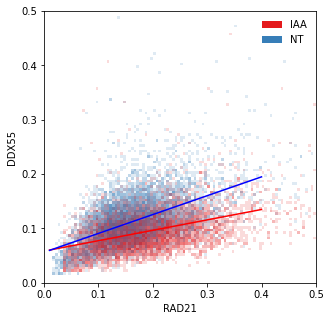

In [382]:
_dat_iaa = dat_iaa.dropna()[(dat_iaa.dropna()["X"]<0.5)&(dat_iaa.dropna()["Y1"]<0.5)]
_dat_nt = dat_nt.dropna()[(dat_nt.dropna()["X"]<0.5)&(dat_nt.dropna()["Y1"]<0.5)]
slope_iaa,intercept_iaa,*_ = linregress(_dat_iaa.dropna()["X"].values,_dat_iaa.dropna()["Y1"].values)
slope_nt,intercept_nt,*_ = linregress(_dat_nt.dropna()["X"].values,_dat_nt.dropna()["Y1"].values)
slope_iaa,slope_nt,intercept_iaa,intercept_nt

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()

da2 = dsshow(
       dat,#.transform({'X':lambda x:np.clip(x,0,.5),'Y1':lambda y:np.clip(y,0,.5),"type":lambda z:z.astype("category")}),
       ds.Point('X', 'Y1'),
       ds.count_cat('type'),
        plot_width=100,
        plot_height=100,
        x_range=(0,.5),
        y_range=(0,.5),
#        shade_hook=partial(tf.dynspread, threshold=0.5,shape="circle", how='over'),
       ax=ax)
plt.legend(handles=da2.get_legend_elements(),frameon=False);

_l_iaa = lambda x: slope_iaa*x + intercept_iaa
_l_nt = lambda x: slope_nt*x + intercept_nt
ax.plot([0.01,0.4],[_l_iaa(0),_l_iaa(0.4)],color="red")
ax.plot([0.01,0.4],[_l_nt(0),_l_nt(0.4)],color="blue")
ax.set_xlabel("RAD21")
ax.set_ylabel("DDX55")
plt.savefig("ddx55-rad21.pdf")

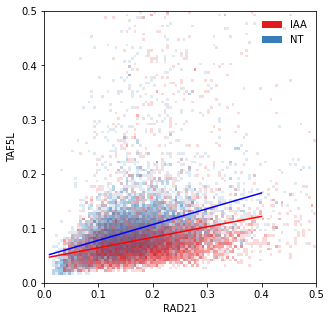

In [383]:
_dat_iaa = dat_iaa.dropna()[(dat_iaa.dropna()["X"]<0.5)&(dat_iaa.dropna()["Y2"]<0.5)]
_dat_nt = dat_nt.dropna()[(dat_nt.dropna()["X"]<0.5)&(dat_nt.dropna()["Y2"]<0.5)]
slope_iaa,intercept_iaa,*_ = linregress(_dat_iaa.dropna()["X"].values,_dat_iaa.dropna()["Y2"].values)
slope_nt,intercept_nt,*_ = linregress(_dat_nt.dropna()["X"].values,_dat_nt.dropna()["Y2"].values)
slope_iaa,slope_nt,intercept_iaa,intercept_nt

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()

da2 = dsshow(
       dat,
       ds.Point('X', 'Y2'),
       ds.count_cat('type'),
        plot_width=100,
        plot_height=100,
        x_range=(0,.5),
        y_range=(0,.5),
#        shade_hook=partial(tf.dynspread, threshold=0.5,shape="circle", how='over'),
       ax=ax)
# ax.set_title(_title)
plt.legend(handles=da2.get_legend_elements(),frameon=False);

_l_iaa = lambda x: slope_iaa*x + intercept_iaa
_l_nt = lambda x: slope_nt*x + intercept_nt
ax.plot([0.01,0.4],[_l_iaa(0),_l_iaa(0.4)],color="red")
ax.plot([0.01,0.4],[_l_nt(0),_l_nt(0.4)],color="blue")
ax.set_xlabel("RAD21")
ax.set_ylabel("TAF5L")
plt.savefig("taf5l-rad21.pdf")

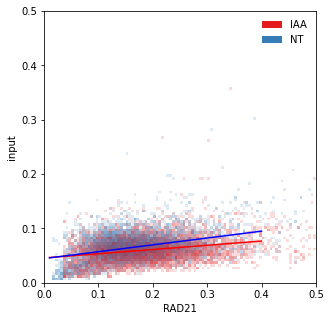

In [384]:
_dat_iaa = dat_iaa.dropna()[(dat_iaa.dropna()["X"]<0.5)&(dat_iaa.dropna()["Y3"]<0.5)]
_dat_nt = dat_nt.dropna()[(dat_nt.dropna()["X"]<0.5)&(dat_nt.dropna()["Y3"]<0.5)]
slope_iaa,intercept_iaa,*_ = linregress(_dat_iaa.dropna()["X"].values,_dat_iaa.dropna()["Y3"].values)
slope_nt,intercept_nt,*_ = linregress(_dat_nt.dropna()["X"].values,_dat_nt.dropna()["Y3"].values)
slope_iaa,slope_nt,intercept_iaa,intercept_nt

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()

da2 = dsshow(
       dat,
       ds.Point('X', 'Y3'),
       ds.count_cat('type'),
        x_range=(0,.5),
        y_range=(0,.5),
        plot_width=100,
        plot_height=100,
#        shade_hook=partial(tf.dynspread, threshold=0.5,shape="circle", how='over'),
       ax=ax)
# ax.set_title(_title)
plt.legend(handles=da2.get_legend_elements(),frameon=False);

_l_iaa = lambda x: slope_iaa*x + intercept_iaa
_l_nt = lambda x: slope_nt*x + intercept_nt
ax.plot([0.01,0.4],[_l_iaa(0),_l_iaa(0.4)],color="red")
ax.plot([0.01,0.4],[_l_nt(0),_l_nt(0.4)],color="blue")
ax.set_xlabel("RAD21")
ax.set_ylabel("input")
plt.savefig("input-rad21.pdf")

In [391]:
# !ssh ghpcc ls /nl/umw_job_dekker/users/sv49w/ALV2021
# !scp *-rad21.pdf ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/

In [19]:
# LET'S ADD GENES AS YET ANOTHER STACKUP TO THE DICT ...
annot_flank = 5_000
annot_binsize = 200
feat_name = "gene"
for k in dfs:
    print(f"stacking genes up for {k} ...")
    aaa = rstacks(
        "pcgene_plus.bb",
        dfs[k],
        flank=annot_flank,
        binsize=annot_binsize,
    )
    bbb = rstacks(
        "pcgene_minus.bb",
        dfs[k],
        flank=annot_flank,
        binsize=annot_binsize,
    )
    stackup_dict[k][feat_name] = aaa - bbb

    
#let's describe our samples that we want to have in Figure 1 ...
fig4_samples.append(feat_name)
titles = fig4_samples

s = feat_name
bw_fnames[s] = "blah"
binsizes[s] = annot_binsize
flanks[s] = annot_flank
limss[s] = (-1,1)
cmps[s] = "coolwarm"
norms[s] = None

stacking genes up for tssp ...
stacking genes up for tssm ...
stacking genes up for ddx55-nt ...
stacking genes up for taf5l-nt ...


#### plotting those running averages is integrated into `plot_stackups` function ...

In [20]:
feat_names.keys()

odict_keys(['tssp', 'tssm', 'ddx55-nt', 'taf5l-nt'])

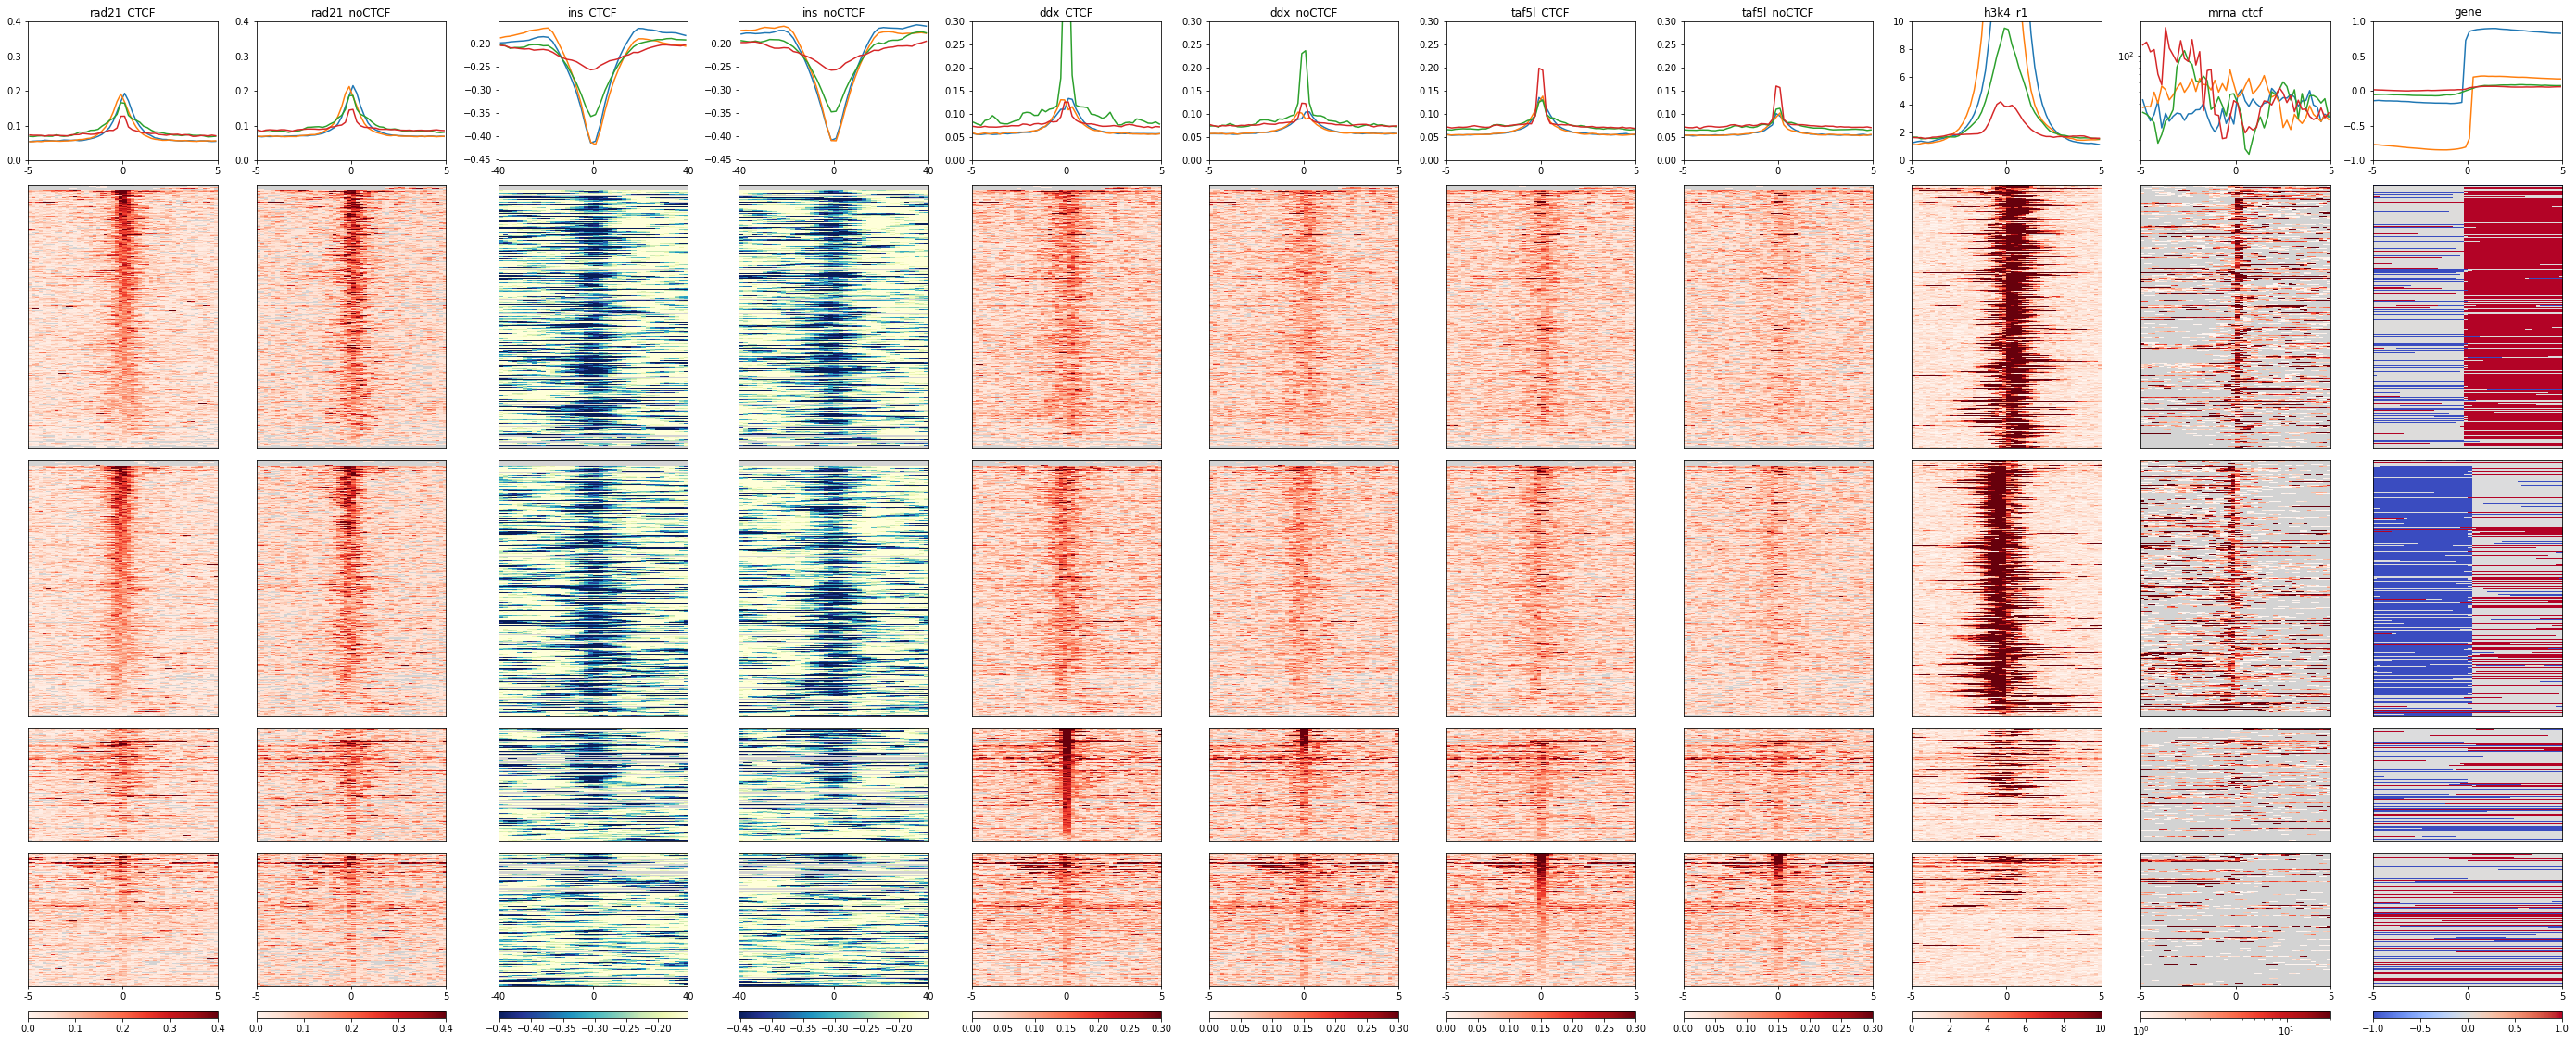

In [79]:
hmss = OrderedDict()

for feature_key in feat_names.keys():
    jjj = reordered_jdxs[feature_key]
    _stackups = stackup_dict[feature_key]
    hmss[feature_key] = [ _stackups[_k][jjj] for _k in fig4_samples ]

_limss = [ limss[_k] for _k in fig4_samples ]
_cmps = [ cmps[_k] for _k in fig4_samples ]
_binsizes = [ binsizes[_k] for _k in fig4_samples ]
_norms = [ norms[_k] for _k in fig4_samples ]

extra_order = None # [7,9]
hmss_order = None # [0,1,2,3,4,5,6,8]
xtra_axs = plot_stackups_sets(extra_order,hmss,titles,_limss,_cmps,_norms,_binsizes,extra_order=extra_order,hmss_order=hmss_order,fillmissing=False,interpolation="nearest")
# xtra_axs - 2 dimensional list of axes, first index - "column"; second index is row - i.e. the stackup group


plt.savefig("Fig4-ddf-taf.pdf")

In [24]:
# # check what we have here locally ...
# ! ls Fig2*pdf
# ! ssh ghpcc ls /nl/umw_job_dekker/users/sv49w/ALV2021
# ! scp Fig2* ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/
# !scp masterlist*.bed ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/
# !scp Fig4-ddf-taf.pdf ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/